In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as colors
import numpy as np 
import numpy.linalg as npl
from random import choices, seed
from pathlib import Path
import os
import sys
os.chdir('../')
from gen_geom import geom
msh = geom()
domaine_size = msh.y.size * msh.x.size
presence_threshold = 0.065
path_case = os.getcwd()
path_data = path_case + '/data'

In [2]:
import pherosensor

from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation, Source
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

from source_localization.cost import Cost
from source_localization.control import Control
from source_localization.adjoint_convection_diffusion_2D import AdjointDiffusionConvectionReaction2DEquation
from source_localization.obs import Obs

from utils.plot_ctrl import plot_ctrl
from utils.superlevel_set import *

In [3]:
colors_dic = {
    'no reg':                '#377eb8',   #'blue'   
    'reg pop dyn':           '#ff7f00',   #'orange'  
    'reg group LASSO':       '#f781bf',   #'pink'
    'reg T + group LASSO':   '#984ea3',   #'purple'    
    'all reg':               '#e41a1c',   #'red' 
} 

In [4]:
def presence_prediction(S):
    presence = [
         superlevel_set(presence_threshold, S[i,:,:]) for i,_ in enumerate(msh.t_array)
     ]
    return presence

def compute_proportion(presence_pred_vs_t, presence_truth_vs_t, msh): 
    miss_rate = np.ones_like(msh.t_array)
    false_discovery_rate = np.ones_like(msh.t_array)
    for i, (presence_pred, presence_truth) in enumerate(zip(presence_pred_vs_t, presence_truth_vs_t)):
        false_presence_pred = presence_pred & (~ presence_truth)
        false_absence_pred = (~ presence_pred) & presence_truth
        volume_false_presence_pred = volume(false_presence_pred, msh.mass_cell*msh.dt)
        volume_false_absence_pred = volume(false_absence_pred, msh.mass_cell*msh.dt)
        volume_presence_truth = volume(presence_truth, msh.mass_cell*msh.dt)
        volume_presence_pred = volume(presence_pred, msh.mass_cell*msh.dt)
        miss_rate[i] = volume_false_absence_pred / volume_presence_truth
        false_discovery_rate[i] = volume_false_presence_pred / volume_presence_pred     
    return miss_rate, false_discovery_rate

# Load the target $S$

In [5]:
S_value = np.load(Path(path_data) / 'S.npy')
ctrl_target = Control(Source(msh, S_value, t=msh.t_array), msh)
ctrl_target.value = np.copy(ctrl_target.background_value)
true_presence = presence_prediction(S_value)
target = {
    'label': 'target', 
    'ctrl': ctrl_target, 
    'ls': 'k', 
    'prediction of presence': true_presence
}

any_presence = [presence.any() for presence in true_presence]

# Load and plot the optimal $S$ without regularization

In [6]:
path_output = path_case + '/output_noreg'
S_o_no_reg = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_no_reg = Control(Source(msh, S_o_no_reg, t=msh.t_array), msh)
ctrl_no_reg.value = np.copy(ctrl_no_reg.background_value)
prediction_presence_no_reg = presence_prediction(S_o_no_reg)
miss_rate_no_reg, false_discovery_rate_no_reg = compute_proportion(prediction_presence_no_reg,true_presence, msh)

no_reg = {
    'label': 'no reg', 
    'ctrl': ctrl_no_reg, 
    'ls': colors_dic['no reg'],  
    'prediction of presence': prediction_presence_no_reg, 
    'miss rate': miss_rate_no_reg,
    'false discovery rate': false_discovery_rate_no_reg
}

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


# Load and plot the optimal $S$ with population dynamic regularization

In [7]:
path_output = path_case + '/output_regPD'
S_o_reg_pop_dyn = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_reg_pop_dyn = Control(Source(msh, S_o_reg_pop_dyn, t=msh.t_array), msh)
ctrl_reg_pop_dyn.value = np.copy(ctrl_reg_pop_dyn.background_value)
prediction_presence_reg_pop_dyn = presence_prediction(S_o_reg_pop_dyn)
miss_rate_reg_pop_dyn, false_discovery_rate_reg_pop_dyn = compute_proportion(prediction_presence_reg_pop_dyn,true_presence, msh)

reg_pop_dyn = {
    'label': 'PD', 
    'ctrl': ctrl_reg_pop_dyn, 
    'ls': colors_dic['reg pop dyn'],  
    'prediction of presence': prediction_presence_reg_pop_dyn, 
    'miss rate': miss_rate_reg_pop_dyn,
    'false discovery rate': false_discovery_rate_reg_pop_dyn
}

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


# Load and plot the optimal $S$ with group LASSO regularization

In [8]:
path_output = path_case + '/output_reggroupLASSO'
S_o_reg_groupLASSO = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_reg_groupLASSO = Control(Source(msh, S_o_reg_groupLASSO, t=msh.t_array), msh)
ctrl_reg_groupLASSO.value = np.copy(ctrl_reg_groupLASSO.background_value)
prediction_presence_reg_groupLASSO = presence_prediction(S_o_reg_groupLASSO)
miss_rate_reg_groupLASSO, false_discovery_rate_reg_groupLASSO = compute_proportion(prediction_presence_reg_groupLASSO,true_presence, msh)

reg_groupLASSO = {
    'label': 'group LASSO', 
    'ctrl': ctrl_reg_groupLASSO, 
    'ls': colors_dic['reg group LASSO'],  
    'prediction of presence': prediction_presence_reg_groupLASSO, 
    'miss rate': miss_rate_reg_groupLASSO,
    'false discovery rate': false_discovery_rate_reg_groupLASSO
}

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


# Load and plot the optimal $S$ with Tikhonov and group LASSO regularization

In [9]:
path_output = path_case + '/output_regTgroupLASSO'
S_o_reg_TgroupLASSO = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_reg_TgroupLASSO = Control(Source(msh, S_o_reg_TgroupLASSO, t=msh.t_array), msh)
ctrl_reg_TgroupLASSO.value = np.copy(ctrl_reg_TgroupLASSO.background_value)
prediction_presence_reg_TgroupLASSO = presence_prediction(S_o_reg_TgroupLASSO)
miss_rate_reg_TgroupLASSO, false_discovery_rate_reg_TgroupLASSO = compute_proportion(prediction_presence_reg_TgroupLASSO,true_presence, msh)

reg_TgroupLASSO = {
    'label': 'T+group LASSO', 
    'ctrl': ctrl_reg_TgroupLASSO, 
    'ls': colors_dic['reg T + group LASSO'],  
    'prediction of presence': prediction_presence_reg_TgroupLASSO, 
    'miss rate': miss_rate_reg_TgroupLASSO,
    'false discovery rate': false_discovery_rate_reg_TgroupLASSO
}

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


# Load and plot the optimal $S$ with all regularizations

In [10]:
path_output = path_case + '/output_allreg'
S_o_allreg = np.load(Path(path_output) / "S_optim.npy").reshape((msh.t_array.size, msh.y.size, msh.x.size))
ctrl_allreg = Control(Source(msh, S_o_allreg, t=msh.t_array), msh)
ctrl_allreg.value = np.copy(ctrl_allreg.background_value)
prediction_presence_allreg = presence_prediction(S_o_allreg)
miss_rate_allreg, false_discovery_rate_allreg = compute_proportion(prediction_presence_allreg,true_presence, msh)

allreg = {
    'label': 'all reg', 
    'ctrl': ctrl_allreg, 
    'ls': colors_dic['all reg'],  
    'prediction of presence': prediction_presence_allreg, 
    'miss rate': miss_rate_allreg,
    'false discovery rate': false_discovery_rate_allreg
}

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


# Comparison of the errors

In [11]:
dic = {
        'target':target,
        'no reg':no_reg, 
        'reg pop dyn':reg_pop_dyn,
        'reg group LASSO': reg_groupLASSO,
        'reg T group LASSO': reg_TgroupLASSO, 
        'all reg': allreg,
    }

save_plot_path = 'TO BE DEFINED'

In [12]:
def plot_sls_comp(
    msh, 
    case_dict, 
    i_t_list, 
    eps, 
    any_presence,
    save_path=None, 
    file_name=None, 
    file_format='eps',
    figsize=(20, 15)
):
    
    fontsize = 25
    lines = []
    labels = []
    fig, ax = plt.subplots(2,len(i_t_list), figsize=figsize)#
    gs = ax[1, 0].get_gridspec()
    for axis in ax[1, :]:
        axis.remove()
    ax_bis = fig.add_subplot(gs[1, :])
    for key in case_dict.keys():
        case = case_dict[key]
        ctrl_xytmap = case['ctrl'].value.reshape((msh.t_array.size, msh.y.size, msh.x.size))
        for index_plot, i_t in enumerate(i_t_list):
            ctrl_map = ctrl_xytmap[i_t,:,:]
            cs = ax[0, index_plot].contour(msh.x-np.min(msh.x), msh.y-np.min(msh.y), ctrl_map>eps, colors=case['ls'], linestyles='dashed', levels=0, linewidths=4)
            if index_plot == 0: 
                lines += cs.legend_elements()[0]
                labels.append(case['label'])                  
            ax[0, index_plot].set_xlabel("$x$ ($m$)", fontsize=fontsize)
            ax[0, 0].set_ylabel("$y$ ($m$)", fontsize=fontsize)
            ax[0, index_plot].set_xlim(0, np.max(msh.x)-np.min(msh.x))
            ax[0, index_plot].set_ylim(0, np.max(msh.y)-np.min(msh.y))
            ax[0, index_plot].set_aspect('equal', adjustable='box')
            ax[0, index_plot].tick_params(labelsize=fontsize - 5)
            title = f'at t = {"{:.2f}".format(msh.t_array[i_t]/60)} min'
            ax[0, index_plot].set_title(title, loc='center', fontsize=fontsize)
        if not key == 'target':
            ax_bis.plot(msh.t_array[any_presence]/60, case['miss rate'][any_presence], color=case['ls'])
            ax_bis.plot(msh.t_array[any_presence]/60, case['false discovery rate'][any_presence], color=case['ls'], ls='dashed')
    ax_bis.plot(-1, 0.5, color='black', ls='solid', label=r'$\rho_{fa}$ miss rate')
    ax_bis.plot(-1, 0.5, color='black', ls='dashed', label=r'$\rho_{fp}$ false discovery rate')
    ax_bis.set_xlabel("$t$ ($min$)", fontsize=fontsize)
    ax_bis.set_ylabel(r"$\rho$", fontsize=fontsize)
    ax_bis.set_xlim(np.min(msh.t_array[any_presence])/60, np.max(msh.t_array[any_presence])/60)
    ax_bis.tick_params(labelsize=fontsize - 5)
    ax_bis.legend(loc='upper left', fontsize=fontsize-5)
    
    fig.legend(lines, labels, fontsize=fontsize-5, loc='upper center', ncol=8, bbox_to_anchor=(0.5, .915))   
    if save_path is not None:
        if not os.path.isdir(Path(save_path)):
            os.makedirs(Path(save_path))
        if file_name is None:
            file_name = 'sls'
        plt.savefig(Path(save_path) / f"{file_name}.{file_format}", format=file_format, bbox_inches="tight")
        plt.close('all')

/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/home/tmalou/anaconda3/envs/pherosensor-new/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


"\nplot_sls_comp(\n    msh, \n    dic, \n    [0, 49, 98], \n    presence_threshold, \n    any_presence,\n    figsize=(20, 20), \n    save_path=save_plot_path,\n    file_name='presence_prediction',\n    file_format='png',\n)\n"

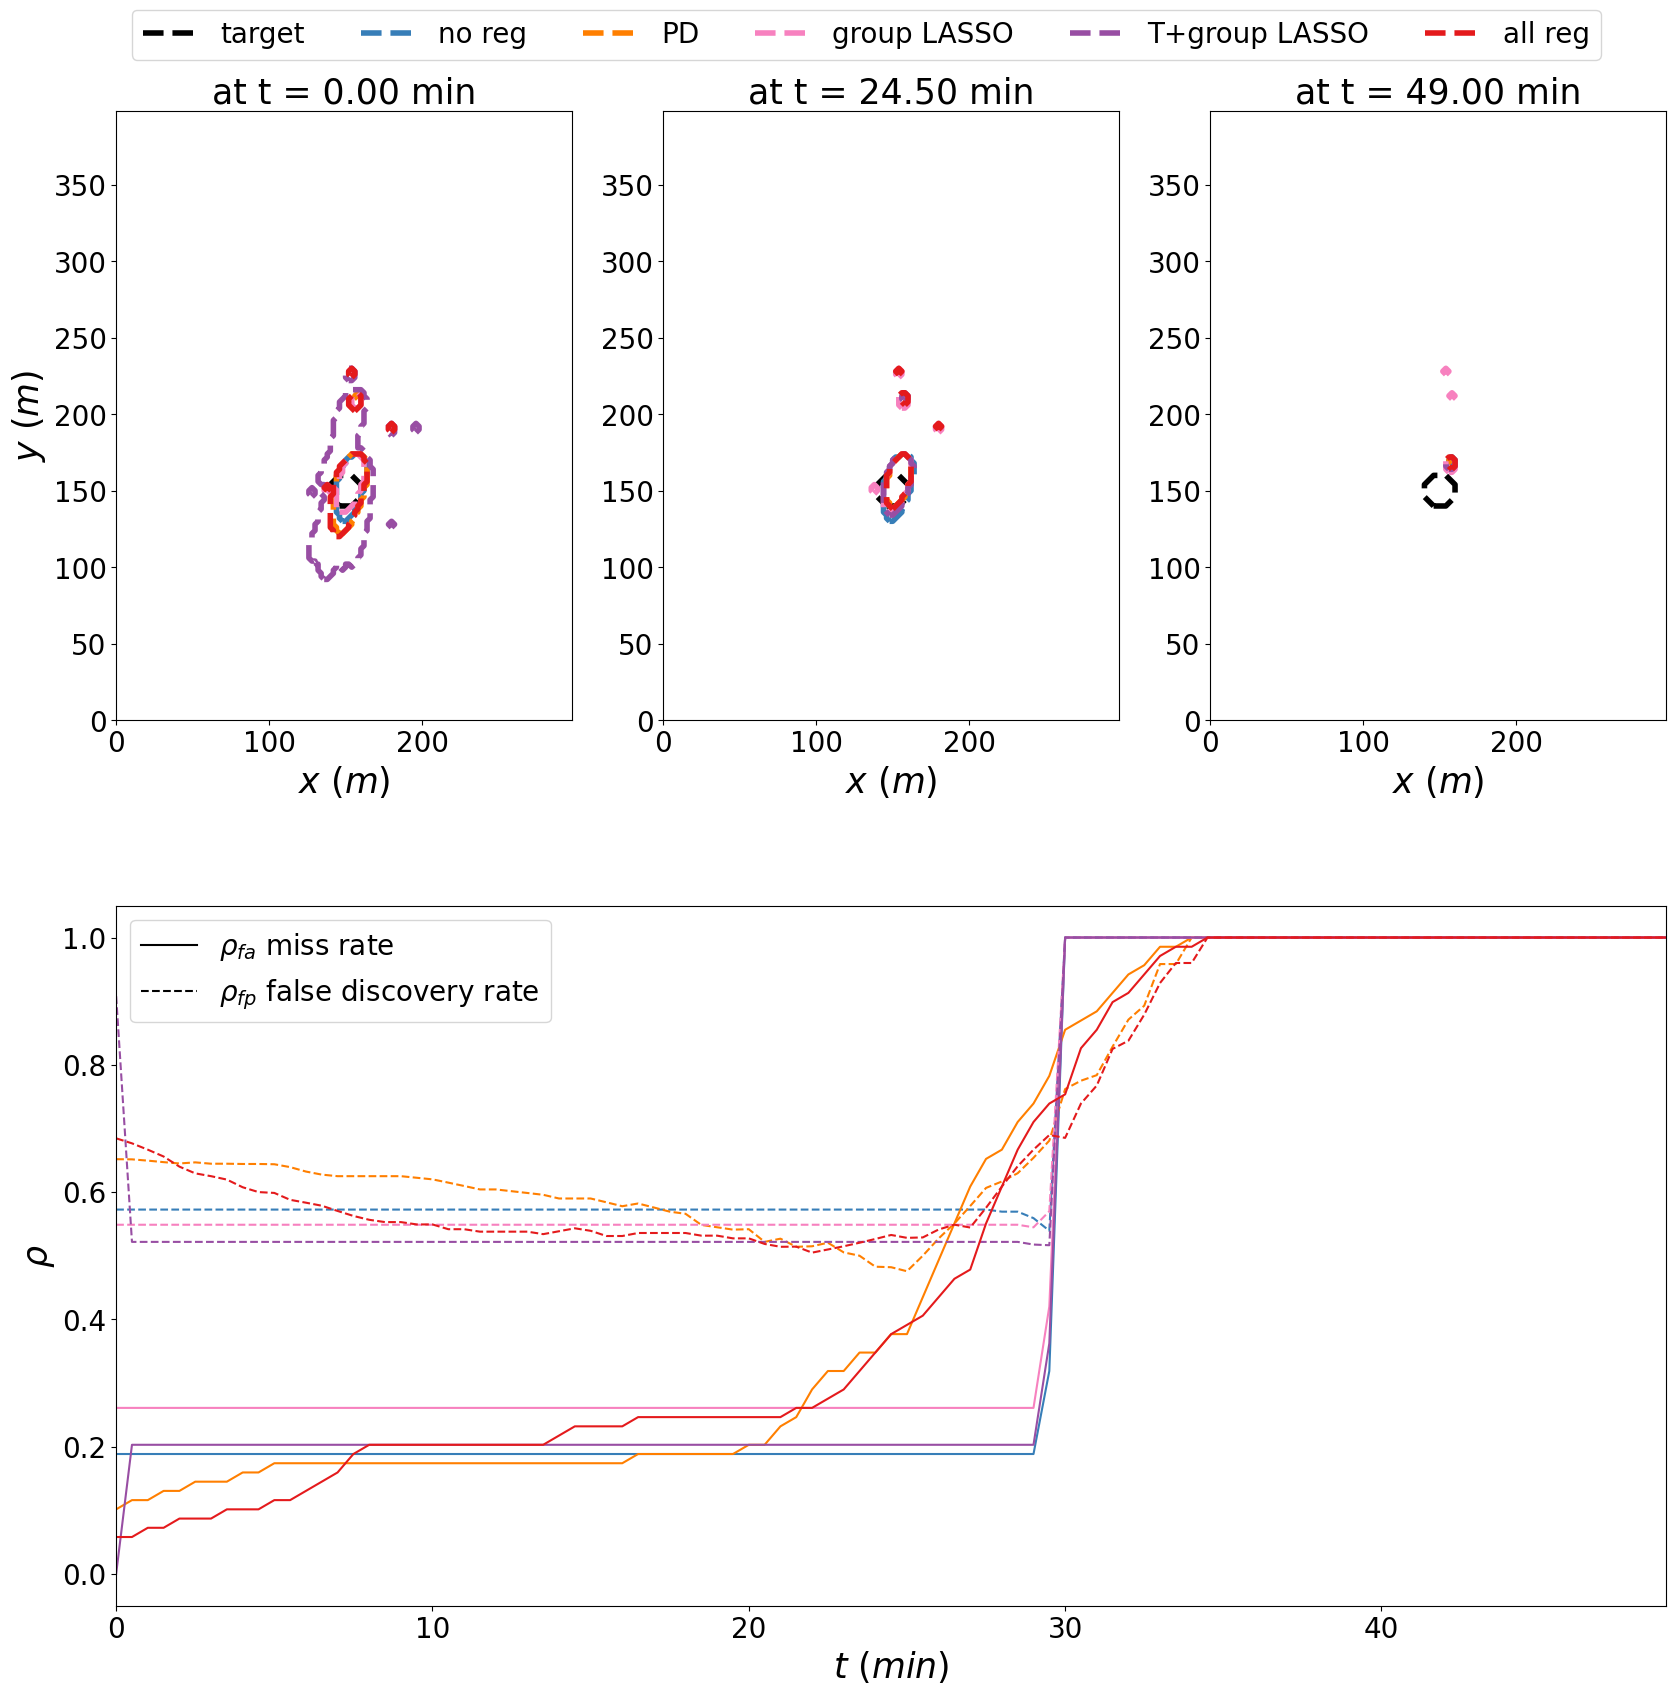

In [13]:

plot_sls_comp(
    msh, 
    dic, 
    [0, 49, 98], 
    presence_threshold, 
    any_presence,
    figsize=(20, 20), 
)
"""
plot_sls_comp(
    msh, 
    dic, 
    [0, 49, 98], 
    presence_threshold, 
    any_presence,
    figsize=(20, 20), 
    save_path=save_plot_path,
    file_name='presence_prediction',
    file_format='png',
)
"""